In [66]:
'''导入必要的包'''
import torch
from torchvision import datasets, transforms
from torch.autograd import  Variable

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean=[0.5], std=[0.5])]) # 修改的位置


'''实现数据集下载'''
data_train = datasets.MNIST(root = "./data/", 
                            train = True, 
                            transform = transform,                             
                            download = True)
data_test = datasets.MNIST(root="./data/",                            
                           train = False,
                           transform = transform,)

[tensor(2), tensor(9), tensor(2), tensor(8), tensor(5), tensor(1), tensor(3), tensor(4), tensor(2), tensor(2), tensor(6), tensor(7), tensor(0), tensor(7), tensor(2), tensor(2), tensor(1), tensor(1), tensor(5), tensor(4), tensor(9), tensor(1), tensor(0), tensor(6), tensor(9), tensor(7), tensor(8), tensor(3), tensor(7), tensor(5), tensor(2), tensor(6), tensor(1), tensor(3), tensor(8), tensor(1), tensor(7), tensor(4), tensor(0), tensor(8), tensor(5), tensor(8), tensor(2), tensor(4), tensor(2), tensor(2), tensor(1), tensor(3), tensor(4), tensor(3), tensor(6), tensor(1), tensor(3), tensor(2), tensor(3), tensor(6), tensor(5), tensor(1), tensor(4), tensor(6), tensor(8), tensor(5), tensor(4), tensor(7)]


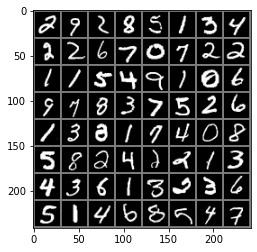

In [67]:
'''使用 torch.utils.data.DataLoader 类对数据装载'''
data_loader_train = torch.utils.data.DataLoader(dataset = data_train,
                                               batch_size = 64,
                                               shuffle = True)
data_loader_test = torch.utils.data.DataLoader(dataset = data_test,
                                               batch_size = 64,
                                               shuffle = True)

'''选取其中一个批次的数据进行预览'''
images, labels = next(iter(data_loader_train))  #使用 iter 和 next 获取其中一个批次的图片数据及标签
img = torchvision.utils.make_grid(images)  # make_grid 类方法将一个批次的图片构造成网格模式

img = img.numpy().transpose(1,2,0)  #完成原始数据类型的转换和数据维度的交换
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img * std + mean
print([labels[i] for i in range(64)])
plt.imshow(img)

In [68]:
'''择搭建一个在结构层次上有所简化的卷积神经网络模型'''
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                        torch.nn.ReLU(),
                                        torch.nn.MaxPool2d(stride=2, kernel_size=2))
        
        self.dense = torch.nn.Sequential(torch.nn.Linear(14*14*128, 1024),
                                        torch.nn.ReLU(),
                                        torch.nn.Dropout(p=0.5),
                                        torch.nn.Linear(1024, 10))
    def forward(self, x): 
        x = self.conv1(x) 
        x = x.view(-1, 14*14*128) 
        x = self.dense(x)
        return x

In [69]:
'''定义在训练之前使用哪种损失函数和优化函数'''
model = Model()
cost = torch.nn.CrossEntropyLoss()  #计算损失值的损失函数使用的是交叉熵
optimizer = torch.optim.Adam(model.parameters())  #优化函数使用的是 Adam 自适应优化算法，需要优化的参数是在 Model 中生成的全部参数

print(model)  #查看搭建好的模型的完整结构

Model(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=25088, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [74]:
'''模型训练和参数优化'''
n_epochs = 5

for epoch in range(n_epochs):
    running_loss = 0.0
    running_correct = 0
    
    for data in data_loader_train:
        X_train, y_train = data
        X_train, y_train = Variable(X_train), Variable(y_train)
        outputs = model(X_train)
        _,pred = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = cost(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.data
        running_correct += torch.sum(pred == y_train.data)
    
    testing_correct = 0
    
    for data in data_loader_test:
        X_test, y_test = data 
        X_test, y_test = Variable(X_test), Variable(y_test) 
        outputs = model(X_test) 
        _, pred = torch.max(outputs.data, 1) 
        testing_correct += torch.sum(pred == y_test.data)
            
    print("Epoch {}: loss = {:.4f}, train accuracy = {:.4f}%, test accuracy = {:.4f}".format(
        epoch, running_loss/len(data_train), 
        100*running_correct/len(data_train),
        100*testing_correct/len(data_test)))

Epoch 0: loss = 0.0007, train accuracy = 98.5133%, test accuracy = 98.4100
Epoch 1: loss = 0.0005, train accuracy = 98.9283%, test accuracy = 98.5900
Epoch 2: loss = 0.0004, train accuracy = 99.3133%, test accuracy = 98.8300
Epoch 3: loss = 0.0003, train accuracy = 99.3667%, test accuracy = 98.7800
Epoch 4: loss = 0.0002, train accuracy = 99.5633%, test accuracy = 98.7800


Predict Label is:
tensor(5) tensor(9) tensor(1) tensor(1) tensor(1) tensor(1) tensor(2) tensor(7) 

tensor(9) tensor(8) tensor(1) tensor(3) tensor(1) tensor(1) tensor(8) tensor(2) 

tensor(8) tensor(5) tensor(5) tensor(9) tensor(7) tensor(4) tensor(0) tensor(0) 

tensor(5) tensor(4) tensor(2) tensor(2) tensor(1) tensor(7) tensor(8) tensor(8) 

tensor(1) tensor(2) tensor(2) tensor(3) tensor(2) tensor(7) tensor(2) tensor(8) 

tensor(9) tensor(8) tensor(5) tensor(8) tensor(1) tensor(5) tensor(8) tensor(8) 

tensor(5) tensor(0) tensor(8) tensor(4) tensor(0) tensor(4) tensor(1) tensor(1) 

tensor(6) tensor(8) tensor(4) tensor(6) tensor(3) tensor(8) tensor(5) tensor(9) 

Real Label is:
tensor(5) tensor(5) tensor(1) tensor(1) tensor(1) tensor(1) tensor(2) tensor(7) 

tensor(9) tensor(8) tensor(1) tensor(3) tensor(1) tensor(1) tensor(8) tensor(2) 

tensor(8) tensor(5) tensor(5) tensor(9) tensor(7) tensor(4) tensor(0) tensor(0) 

tensor(5) tensor(4) tensor(2) tensor(2) tensor(1) tensor(7) tenso

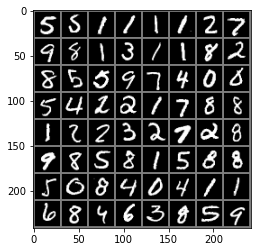

In [75]:
data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                              batch_size=64,
                                              shuffle=True)
X_test, y_test = next(iter(data_loader_test))
inputs = Variable(X_test)
pred = model(inputs)
_, pred = torch.max(pred, 1)

print('Predict Label is:')
for i in range(len(pred.data)):
    print(pred.data[i], end=' ')
    if (i+1) % 8 == 0:
        print('\n')
        
print('Real Label is:')
for i in range(len(y_test)):
    print(y_test.data[i], end=' ')
    if (i+1) % 8 == 0:
        print('\n')
        
img = torchvision.utils.make_grid(X_test)
img = img.numpy().transpose(1, 2, 0)

std = [0.5, 0.5, 0.5]
mean = [0.5, 0.5, 0.5]
img = img * std + mean
plt.imshow(img)

test_correct = 0
for i in range(len(pred)):
    if pred.data[i]==y_test.data[i]:
        test_correct += 1
print('test_correct:{:.4f}%'.format(100*test_correct/len(pred)))
